In [200]:
'''
author: Kaylx Jang
'''
import tensorflow as tf
import os, sys
import time
import numpy as np
import cv2
import pickle
import random

from tqdm import tqdm

from PIL import Image
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

the_time = int(time.time())


IMG_WIDTH = 1024
IMG_HEIGHT = 1024
IMG_CHANNELS = 3

TRAIN_PATH_IMAGES = 'X:/Python/tensorflow_files/datasets/beckman_laser_institue/rat_airway/custom1_rename/train/oct_images'
TRAIN_PATH_SEG = 'X:/Python/tensorflow_files/datasets/beckman_laser_institue/rat_airway/custom1_rename/train/segmentation' 
TEST_PATH_IMAGES = 'X:/Python/tensorflow_files/datasets/beckman_laser_institue/rat_airway/custom1_rename/test/oct_images'
TEST_PATH_SEG = 'X:/Python/tensorflow_files/datasets/beckman_laser_institue/rat_airway/custom1_rename/train/segmentation' 

#train_ids = os.listdir(TRAIN_PATH_IMAGES)
#test_ids = next(os.walk(TEST_PATH))[1]
#print(train_ids)

#print((os.listdir(TRAIN_PATH_IMAGES)))

print('Done Here')

Done Here


In [201]:
#create 'empty' zero array, data will be added later
X_train = np.zeros((len(os.listdir(TRAIN_PATH_IMAGES)), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8) #unet expects unsigned integers
y_train = np.zeros((len(os.listdir(TRAIN_PATH_SEG)), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool) #prediction is a boolean

# data handling
print('Resizing training images from folders: "oct_images" and "segmentation"')
for n, filename_ in tqdm(enumerate(os.listdir(TRAIN_PATH_IMAGES)), total=len(os.listdir(TRAIN_PATH_IMAGES))):
    #print(n)
    #print(filename_) 
    #print(len(os.listdir(TRAIN_PATH_IMAGES)))
    #print(TRAIN_PATH_IMAGES + '/' + filename_)
    
    img = cv2.imread(TRAIN_PATH_IMAGES + '/' + filename_) #watch channel depth index, could be off if non-bmp used
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    

seg = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, filename_ in tqdm(enumerate(os.listdir(TRAIN_PATH_SEG)), total=len(os.listdir(TRAIN_PATH_SEG))):
    #print(n)
    #print(filename_) 
    #print(len(os.listdir(TRAIN_PATH_SEG)))
    #print(TRAIN_PATH_SEG + '/' + filename_)
    
    seg = cv2.imread(TRAIN_PATH_SEG + '/' + filename_) #watch channel depth index, could be off if non-bmp used
    seg = resize(seg, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    y_train[n] = seg
    

X_test = np.zeros((len(os.listdir(TEST_PATH_IMAGES)), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, filename_ in tqdm(enumerate(os.listdir(TEST_PATH_IMAGES)), total=len(os.listdir(TRAIN_PATH_IMAGES))):
    img = cv2.imread(TEST_PATH_IMAGES + '/' + filename_) #watch channel depth index, could be off if non-bmp used
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img    
    
#The third progress bar has a small glitch (stops at 23% or 420 images) because thats all the train/validation data

MemoryError: Unable to allocate 5.31 GiB for an array with shape (1814, 1024, 1024, 3) and data type uint8

In [6]:
# save datasets
import pickle

pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

In [5]:
# load datasets
X_train = pickle.load(open("X_train.pickle", "rb")) 
y_train = pickle.load(open("y_train.pickle", "rb"))
X_test = pickle.load(open("X_test.pickle", "rb"))

In [185]:
seed = 42
np.random.seed = seed

LOG_NAME = "rat_airway_unet_{}_{}".format(IMG_HEIGHT, int(the_time))

FILTERS = 16
KERNEL_SIZE = (3, 3)
MAX_POOLING_SIZE = (2, 2)

#U-net model
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

#normalizing inputs to 8-bit or 0-255 grayscale
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)

#contraction path
#padding so output image same as input image
#Conv2D(filters, kernel_size)
c1 = tf.keras.layers.Conv2D(FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(normalized)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D(MAX_POOLING_SIZE)(c1)

c2 = tf.keras.layers.Conv2D(2*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(2*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D(MAX_POOLING_SIZE)(c2)

c3 = tf.keras.layers.Conv2D(4*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(4*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D(MAX_POOLING_SIZE)(c3)

c4 = tf.keras.layers.Conv2D(8*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(8*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D(MAX_POOLING_SIZE)(c4)

c5 = tf.keras.layers.Conv2D(16*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(16*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#expansive path
u6 = tf.keras.layers.Conv2DTranspose(8*FILTERS, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(8*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(8*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(4*FILTERS, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(4*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(4*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(2*FILTERS, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(2*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(2*FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(FILTERS, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(FILTERS, KERNEL_SIZE, activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_rat_airway.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='rat_airway_unet_{}_{}'.format(IMG_HEIGHT, the_time))
        ]
        

results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
#batch size was 16, increasing this may prevent ResourceExhaustedError

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 512, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 512, 512, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 512, 512, 16) 0           conv2d_57[0][0]                  
____________________________________________________________________________________________

1632/1632 [==============================] - 60s 37ms/sample - loss: 0.0505 - accuracy: 0.9882 - val_loss: 0.0167 - val_accuracy: 0.9927
Epoch 2/25
1632/1632 [==============================] - 54s 33ms/sample - loss: 0.0108 - accuracy: 0.9937 - val_loss: 0.0120 - val_accuracy: 0.9927
Epoch 3/25
1632/1632 [==============================] - 54s 33ms/sample - loss: 0.0090 - accuracy: 0.9937 - val_loss: 0.0112 - val_accuracy: 0.9927
Epoch 4/25
1632/1632 [==============================] - 54s 33ms/sample - loss: 0.0088 - accuracy: 0.9940 - val_loss: 0.0107 - val_accuracy: 0.9945
Epoch 5/25
1632/1632 [==============================] - 54s 33ms/sample - loss: 0.0083 - accuracy: 0.9959 - val_loss: 0.0105 - val_accuracy: 0.9962
Epoch 6/25
1632/1632 [==============================] - 54s 33ms/sample - loss: 0.0079 - accuracy: 0.9967 - val_loss: 0.0094 - val_accuracy: 0.9958
Epoch 7/25
1632/1632 [==============================] - 54s 33ms/sample - loss: 0.0068 - accuracy: 0.9971 - val_loss: 0.007

420/420 [==============================] - 5s 12ms/sample


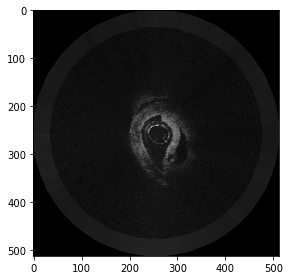

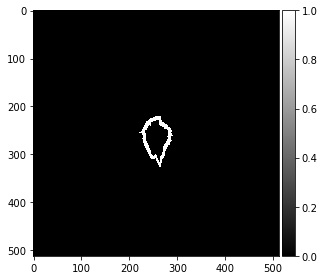

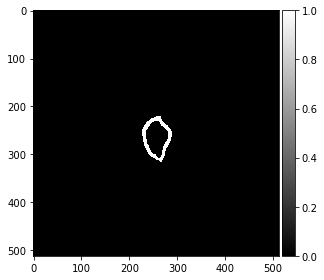

In [186]:
import random
idx = random.randint(0, len(X_train))

predict_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
predict_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
predict_test = model.predict(X_test, verbose=1)

# threshold above 0.5 is a 1, so binary
predict_train_t = (predict_train > 0.5).astype(np.uint8)
predict_val_t = (predict_val > 0.5).astype(np.uint8)
predict_test_t = (predict_test > 0.5).astype(np.uint8)

#sanity check on some random training samples
ix = random.randint(0, len(predict_train_t))
imshow(X_train[ix], cmap='gray')
plt.show()
imshow(np.squeeze(y_train[ix]), cmap='gray')
plt.show()
imshow(np.squeeze(predict_train_t[ix]), cmap='gray')
plt.show()

177


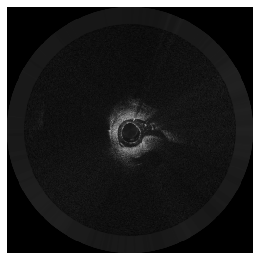

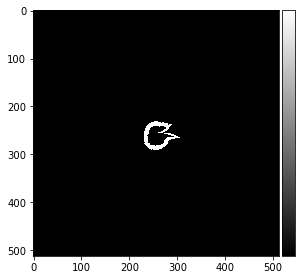

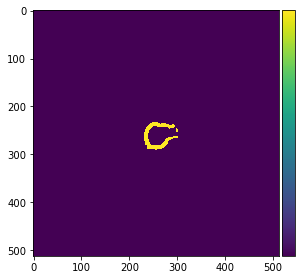

2


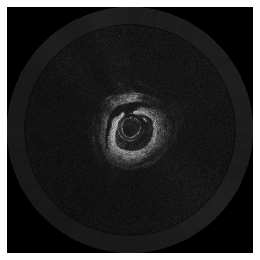

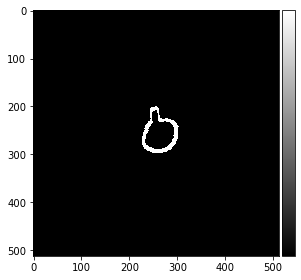

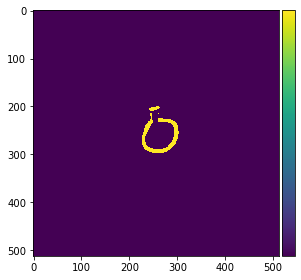

10


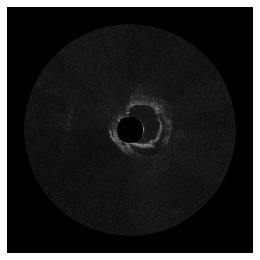

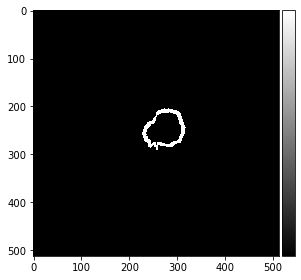

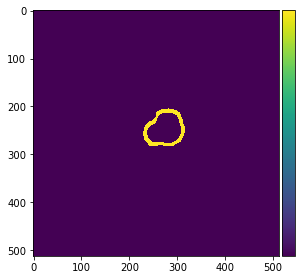

In [198]:
# not using plt.show() stops for loop halfway for some reason
n = 0
for n in range(3):
    dir_X_train = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_result_X_train'.format(IMG_HEIGHT, the_time)
    ix = random.randint(0, len(predict_val_t))
    print(ix)
    #plot matrix or array as an image, grayscale
    imshow(X_train[int(X_train.shape[0]*0.9):][ix], cmap='gray')
    plt.axis('off')
    plt.savefig(dir_X_train + '.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    #save to .png (plt cant save as .bmp) then save as .bmp and delete .png
    handle = Image.open(dir_X_train + '.png')
    handle.save(dir_X_train + '.bmp')
    os.remove(dir_X_train + '.png')
    #print(X_train[int(X_train.shape[0]*0.9):][ix])
        
    dir_y_train = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_result_y_train'.format(IMG_HEIGHT, the_time)
    #plot matrix or array as an image, grayscale
    imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]), cmap='gray')
    plt.axis('off')
    plt.savefig(dir_y_train + '.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    #save to .png (plt cant save as .bmp) then save as .bmp and delete .png
    handle = Image.open(dir_y_train + '.png')
    handle.save(dir_y_train + '.bmp')
    os.remove(dir_y_train + '.png')
    #print(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
    
    dir_y_val = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_result_y_val'.format(IMG_HEIGHT, the_time)
    #plot matrix or array as an image, grayscale   
    imshow(np.array(np.squeeze(predict_val_t[ix]), dtype=bool)) #dtype=bool is used bc matrix is binary, not boolean like the previous arrays
    plt.axis('off')
    plt.savefig(dir_y_val + '.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    #save to .png (plt cant save as .bmp) then save as .bmp and delete .png
    handle = Image.open(dir_y_val + '.png')
    handle.save(dir_y_val + '.bmp')
    os.remove(dir_y_val + '.png')
    #print(np.array(np.squeeze(predict_val_t[ix]), dtype=bool))
    
    #imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]), cmap='gray')
    #plt.savefig('X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_result_y_train.png'.format(IMG_HEIGHT, the_time))
    #plt.show()
    
    #imshow(np.squeeze(predict_val_t[ix]), cmap='gray')
    #plt.savefig('X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_result_val.png'.format(IMG_HEIGHT, the_time))
    #plt.show()

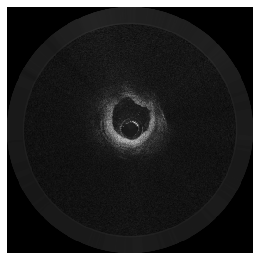

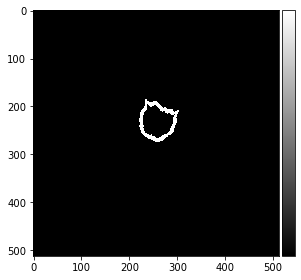

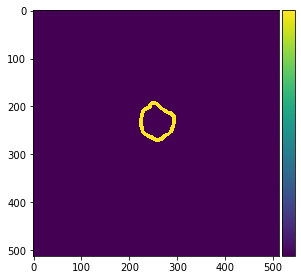

125


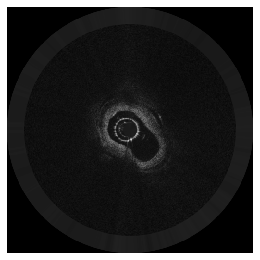

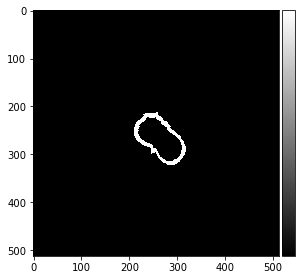

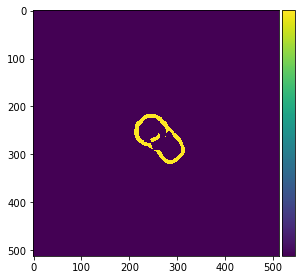

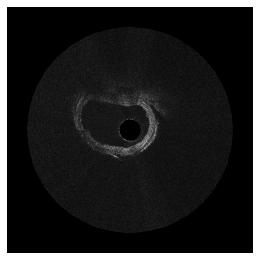

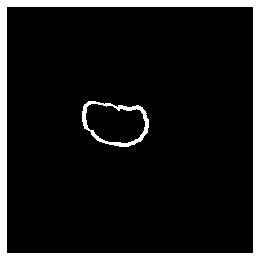

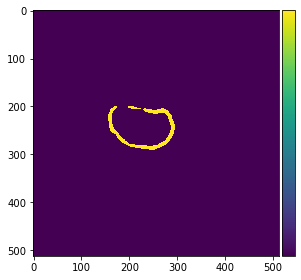

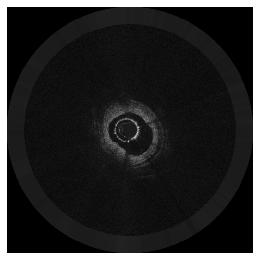

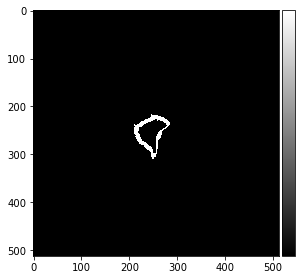

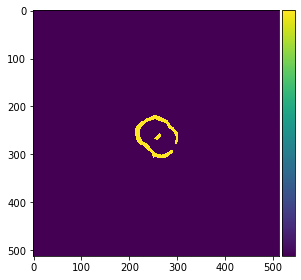

In [199]:
# not using plt.show() stops for loop halfway for some reason
dir_X_train = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_1_result_X_train'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale
imshow(X_train[int(X_train.shape[0]*0.9):][155], cmap='gray')
plt.axis('off')
plt.savefig(dir_X_train + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_X_train + '.png')
handle.save(dir_X_train + '.bmp')
os.remove(dir_X_train + '.png')
#print(X_train[int(X_train.shape[0]*0.9):][ix])

dir_y_train = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_1_result_y_train'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][155]), cmap='gray')
plt.axis('off')
plt.savefig(dir_y_train + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_y_train + '.png')
handle.save(dir_y_train + '.bmp')
os.remove(dir_y_train + '.png')
#print(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))

dir_y_val = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_1_result_y_val'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale   
imshow(np.array(np.squeeze(predict_val_t[155]), dtype=bool)) #dtype=bool is used bc matrix is binary, not boolean like the previous arrays
plt.axis('off')
plt.savefig(dir_y_val + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_y_val + '.png')
handle.save(dir_y_val + '.bmp')
os.remove(dir_y_val + '.png')
#print(np.array(np.squeeze(predict_val_t[ix]), dtype=bool))


dir_X_train = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_2_result_X_train'.format(IMG_HEIGHT, the_time)
ix = random.randint(0, len(predict_val_t))
print(ix)
#plot matrix or array as an image, grayscale
imshow(X_train[int(X_train.shape[0]*0.9):][103], cmap='gray')
plt.axis('off')
plt.savefig(dir_X_train + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_X_train + '.png')
handle.save(dir_X_train + '.bmp')
os.remove(dir_X_train + '.png')
#print(X_train[int(X_train.shape[0]*0.9):][ix])

dir_y_train = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_2_result_y_train'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][103]), cmap='gray')
plt.axis('off')
plt.savefig(dir_y_train + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_y_train + '.png')
handle.save(dir_y_train + '.bmp')
os.remove(dir_y_train + '.png')
#print(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))

dir_y_val = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_2_result_y_val'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale   
imshow(np.array(np.squeeze(predict_val_t[103]), dtype=bool)) #dtype=bool is used bc matrix is binary, not boolean like the previous arrays
plt.axis('off')
plt.savefig(dir_y_val + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_y_val + '.png')
handle.save(dir_y_val + '.bmp')
os.remove(dir_y_val + '.png')
#print(np.array(np.squeeze(predict_val_t[ix]), dtype=bool))
    

dir_X_train = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_3_result_X_train'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale
imshow(X_train[int(X_train.shape[0]*0.9):][178], cmap='gray')
plt.axis('off')
plt.savefig(dir_X_train + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_X_train + '.png')
handle.save(dir_X_train + '.bmp')
os.remove(dir_X_train + '.png')
#print(X_train[int(X_train.shape[0]*0.9):][ix])

dir_y_train = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_3_result_y_train'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][178]), cmap='gray')
plt.axis('off')
plt.savefig(dir_y_train + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_y_train + '.png')
handle.save(dir_y_train + '.bmp')
os.remove(dir_y_train + '.png')
#print(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))

dir_y_val = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_3_result_y_val'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale   
imshow(np.array(np.squeeze(predict_val_t[178]), dtype=bool)) #dtype=bool is used bc matrix is binary, not boolean like the previous arrays
plt.axis('off')
plt.savefig(dir_y_val + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_y_val + '.png')
handle.save(dir_y_val + '.bmp')
os.remove(dir_y_val + '.png')
#print(np.array(np.squeeze(predict_val_t[ix]), dtype=bool))


dir_X_train = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_4_result_X_train'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale
imshow(X_train[int(X_train.shape[0]*0.9):][33], cmap='gray')
plt.axis('off')
plt.savefig(dir_X_train + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_X_train + '.png')
handle.save(dir_X_train + '.bmp')
os.remove(dir_X_train + '.png')
#print(X_train[int(X_train.shape[0]*0.9):][ix])

dir_y_train = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_4_result_y_train'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][33]), cmap='gray')
plt.axis('off')
plt.savefig(dir_y_train + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_y_train + '.png')
handle.save(dir_y_train + '.bmp')
os.remove(dir_y_train + '.png')
#print(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))

dir_y_val = 'X:/Python/tensorflow_files/project_bli_oct/pics/rat_airway_unet_{}_{}_4_result_y_val'.format(IMG_HEIGHT, the_time)
#plot matrix or array as an image, grayscale   
imshow(np.array(np.squeeze(predict_val_t[33]), dtype=bool)) #dtype=bool is used bc matrix is binary, not boolean like the previous arrays
plt.axis('off')
plt.savefig(dir_y_val + '.png', bbox_inches='tight', pad_inches=0)
plt.show()
#save to .png (plt cant save as .bmp) then save as .bmp and delete .png
handle = Image.open(dir_y_val + '.png')
handle.save(dir_y_val + '.bmp')
os.remove(dir_y_val + '.png')
#print(np.array(np.squeeze(predict_val_t[ix]), dtype=bool))

In [ ]:
            
    a = imshow(X_train[int(X_train.shape[0]*0.9):][ix], cmap='gray')
    plt.axis('off')
    plt.savefig(dir_X_train + '.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    cbar = plt.colorbar(a)
    #save to .png (plt cant save as .bmp) then save as .bmp and delete .png
    handle = Image.open(dir_X_train + '.png')
    handle.save(dir_X_train + '.bmp')
    os.remove(dir_X_train + '.png')

In [ ]:
read all images in file
display
modify images
display
resize
display
save .bmp images in separate file

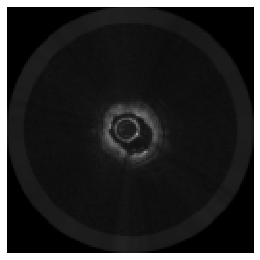

[[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0

In [18]:
# https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import random

# load data, already reshaped
ix = random.randint(0, len(predict_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix], cmap='gray')
plt.axis('off')
plt.show()
print(X_train)
X_train = X_train.astrype 